# Demonstration of Bayesian Optimization on Various Test Functions

This notebook shows how to do Bayesian Optimization using this package by Fernando Nogueira:

- [Bayesian Optimization: Open source constrained global optimization tool for Python](https://github.com/fmfn/BayesianOptimization) (2014)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, gridspec
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import minimize

from bayes_opt import BayesianOptimization, UtilityFunction

In [2]:
from platform import python_version
python_version()

'3.7.8'

In [3]:
# Functions to plot the Gaussian process and utility function

def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    steps = len(optimizer.space)
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    
    fig, axes = plt.subplots(2, 1, figsize=(9, 7))
    
    ax = axes[0]
    ax.plot(x, y, linewidth=3, label='Target')
    ax.plot(x_obs.flatten(), y_obs, 'd', label=u'Observations', color='r')
    ax.plot(x, mu, '--', color='k', label='Prediction')

    ax.fill(np.concatenate([x, x[::-1]]), 
            np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
            alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    ax.set_ylabel('f(x)')
    ax.set_xlabel('x')
    ax.set_title(f'Gaussian Process and Utility Function After {steps} Steps')
    ax.grid()
    ax.legend(bbox_to_anchor=(1, 0.5))
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    
    ax = axes[1]
    ax.plot(x, utility, label='Utility function', color='purple')
    ax.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next best guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    ax.set_ylim((0, np.max(utility) + 0.5))
    ax.set_ylabel('Utility')
    ax.set_xlabel('x')
    ax.grid()
    ax.legend(bbox_to_anchor=(1, 0.5))
    
    return fig

## Demonstration on simple 1-D function 

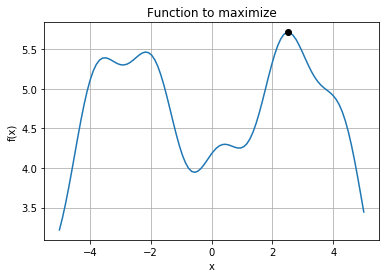

In [4]:
def function_to_maximize(x):
    return -0.05*x**2 - np.cos(x) + 0.25*np.sin(3*x + 0.8) + 5

X = np.linspace(-5, 5, 100)
Y = function_to_maximize(X)

# Compute minimum numerically
sol = minimize(lambda x: 1 / function_to_maximize(x), 2)
assert sol.status == 0
min_pt = sol.x, 1 / sol.fun

plt.plot(X, Y)
plt.plot(*min_pt, 'ko')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function to maximize')
plt.grid()

In [5]:
# Define bounded region of parameter space
pbounds = {'x': (-5, 5)}

# Initialize optimizer
optimizer = BayesianOptimization(
    f=function_to_maximize,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [6]:
# Start with a few random guesses
optimizer.maximize(
    init_points=2,
    n_iter=0,
)

|   iter    |  target   |     x     |
-------------------------------------
|  1        |  4.042    | -0.8298   |
|  2        |  5.574    |  2.203    |


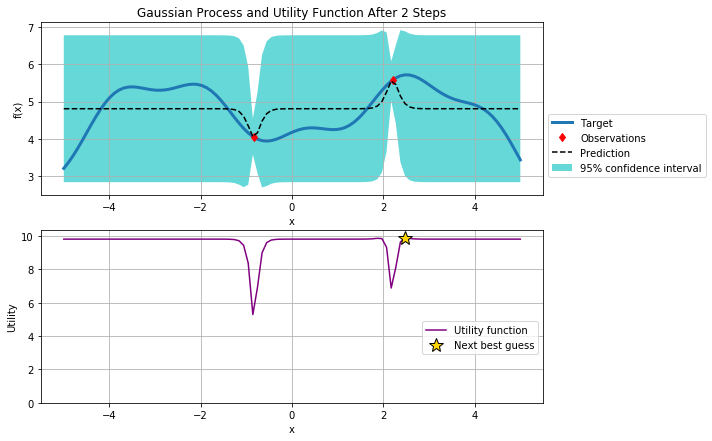

In [7]:
plot_gp(optimizer, X.reshape(-1, 1), Y.reshape(-1, 1))
plt.savefig(f'bayes-opt-GP-util-plot-{len(optimizer.res):3d}.png', dpi=150)
plt.show()

|   iter    |  target   |     x     |
-------------------------------------
|  3        |  5.574    |  2.203    |
|  4        |  5.304    |  3.17     |
|  5        |  3.217    | -5.0      |


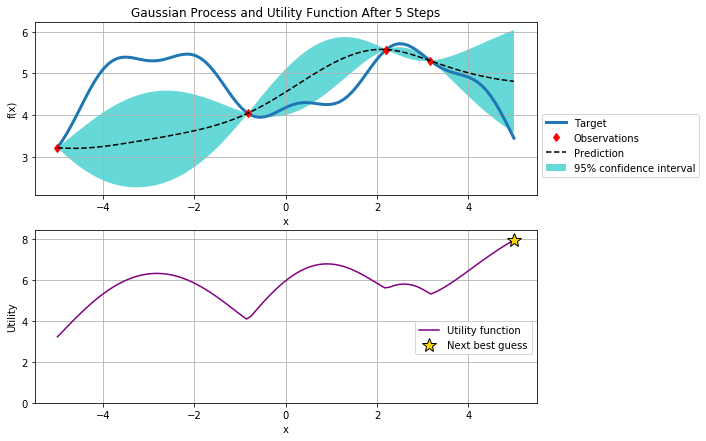

In [8]:
# Choose more points with bayesian optimization
optimizer.maximize(
    init_points=0,
    n_iter=3,
)

plot_gp(optimizer, X.reshape(-1, 1), Y.reshape(-1, 1))
plt.savefig(f'bayes-opt-GP-util-plot-{len(optimizer.res):3d}.png', dpi=150)
plt.show()

|   iter    |  target   |     x     |
-------------------------------------
|  6        |  3.443    |  5.0      |
|  7        |  4.257    |  1.004    |


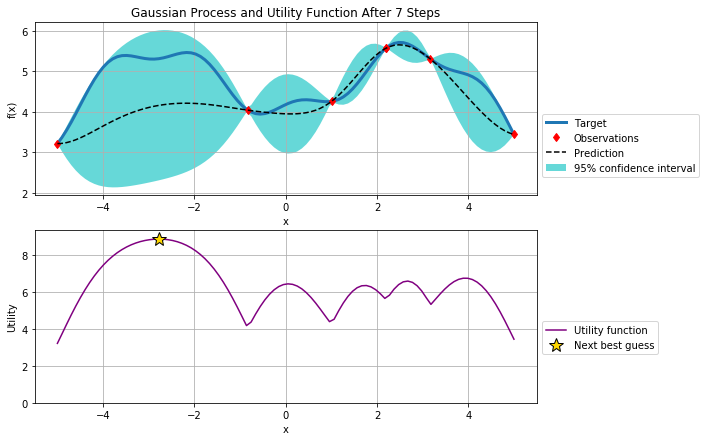

In [9]:
# Choose more points with bayesian optimization
optimizer.maximize(
    init_points=0,
    n_iter=2,
)

plot_gp(optimizer, X.reshape(-1, 1), Y.reshape(-1, 1))
plt.savefig(f'bayes-opt-GP-util-plot-{len(optimizer.res):3d}.png', dpi=150)
plt.show()

In [10]:
x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
y_obs = np.array([res["target"] for res in optimizer.res])
mu, sigma = posterior(optimizer, x_obs, y_obs, grid=X.reshape(-1, 1))

In [11]:
posterior_max_x = X[mu.argmax()]
posterior_max_x, function_to_maximize(posterior_max_x)

(2.474747474747475, 5.712616360557702)

In [12]:
sample_max_x = optimizer.max['params']['x']
sample_max_x, function_to_maximize(sample_max_x)

(2.2032449344215808, 5.57414077432433)

|   iter    |  target   |     x     |
-------------------------------------
|  8        |  5.33     | -2.689    |
|  9        |  5.392    | -3.491    |


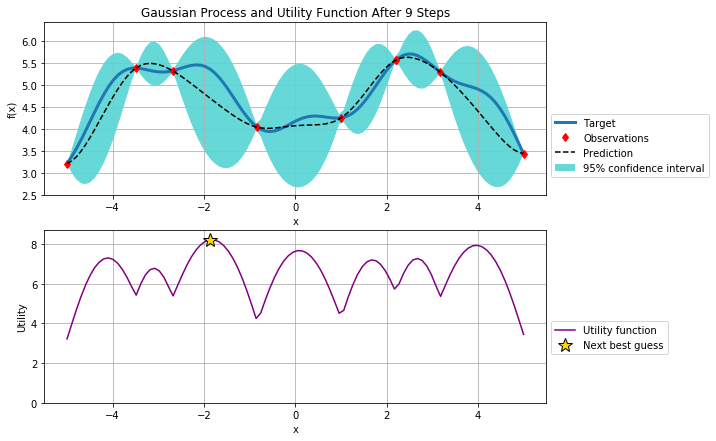

In [13]:
# Choose more points with bayesian optimization
optimizer.maximize(
    init_points=0,
    n_iter=2,
)

plot_gp(optimizer, X.reshape(-1, 1), Y.reshape(-1, 1))
plt.savefig(f'bayes-opt-GP-util-plot-{len(optimizer.res):3d}.png', dpi=150)
plt.show()

In [14]:
optimizer.max

{'target': 5.57414077432433, 'params': {'x': 2.2032449344215808}}

## Test on standard otpimization test functions

In [15]:
# Plotting functions

def generate_plot_data(f, xlim, ylim, nx=100, ny=100):
    X = np.linspace(*xlim, nx)
    Y = np.linspace(*ylim, ny)
    X, Y = np.meshgrid(X, Y)
    Z = f(X, Y)
    return X, Y, Z


def show_3d_surface_plot(X, Y, Z, zlim=(0, 100), title=None):
    """Make 3D surface plot"""
    fig = plt.figure(figsize=(10, 5))
    ax = fig.gca(projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.gist_rainbow,
                           linewidth=0, antialiased=False)

    # Customize the axes.
    ax.set_zlim(*zlim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if title:
        ax.set_title(title)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    return ax


def show_contour_plot(X, Y, Z, minima=None, fmt='%.0f',
                      txt_offset=(5, -3), title=None):
    fig, ax = plt.subplots(figsize=(5,5))
    plt.contour(X, Y, Z)
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=1, fmt=fmt, fontsize=10)
    if minima:
        # Show all the local minima as points
        for i, m in enumerate(minima):
            ax.plot(*m, 'ok')
            ax.annotate(f'$m_{i}$', m, xytext=txt_offset,
                        textcoords='offset points')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if title:
        ax.set_title(title)
    ax.grid()
    return ax


def show_contour_plot_with_pt(X, Y, Z, pt, minima=None, fmt='%.0f',
                              txt_offset=(5, -3), title=None):
    # Show a countour plot with an additional point to
    # indicate the current solution
    ax = show_contour_plot(X, Y, Z, minima=minima, fmt=fmt,
                      txt_offset=txt_offset, title=title)
    ax.plot(*pt, 'xr')
    ax.annotate(f'pt', pt, xytext=txt_offset, color='r',
                textcoords='offset points')
    return ax

# Rosenbrock function

The Rosenbrock function is commonly used to test the performance of optimization algorithms:

$$f(x,y) = (a - x)^2 + b*(y - x^2)^2$$

https://en.wikipedia.org/wiki/Rosenbrock_function

The global minimum is at $(x,y)=(a, a^2)$ which is inside a long, narrow, parabolic shaped flat valley.  Usually these parameters are set such that $a=1$ and $b=100$.

In [16]:
def rosenbrock(x, y, a=1, b=100):
    """Rosenbrock function"""
    return (a - x)**2 + b*(y - x**2)**2

min_rosenbrock = [(1, 1)]
assert np.isclose(rosenbrock(*min_rosenbrock[0]), 0)

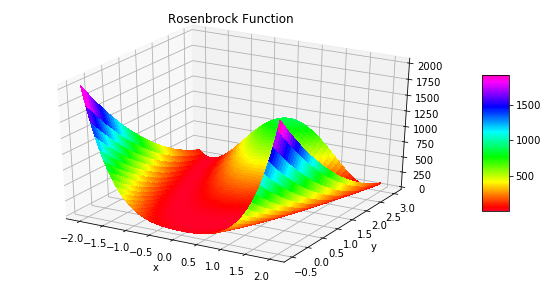

In [17]:
X, Y, Z = generate_plot_data(rosenbrock, xlim=(-2, 2), ylim=(-0.5, 3))
show_3d_surface_plot(X, Y, Z, zlim=(0, Z.max()), title='Rosenbrock Function')
plt.show()

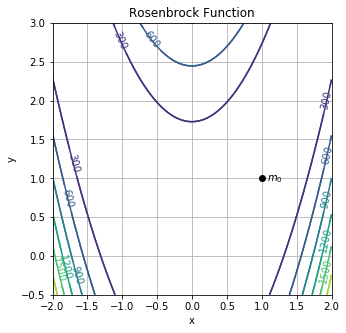

In [18]:
ax = show_contour_plot(X, Y, Z, min_rosenbrock, title='Rosenbrock Function')
plt.show()

## Himmelblau's function

Himmelblau's function is a multi-modal function:

$$f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$$

- https://en.wikipedia.org/wiki/Himmelblau%27s_function

In [19]:
def himmelblau(x, y):
    """Himmelblau's function"""
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

# Minima
min_himmelblau = [
    (3, 2),
    (-2.805118, 3.131312),
    (-3.779310, -3.283186),
    (3.584428, -1.848126)
]
assert all(np.isclose([himmelblau(*m) for m in min_himmelblau], 0))

# Maximum
assert np.isclose(himmelblau(-0.270845, -0.923039), 181.617)

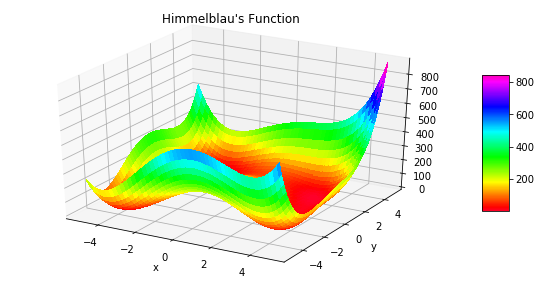

In [20]:
X, Y, Z = generate_plot_data(himmelblau, xlim=(-5, 5), ylim=(-5, 5))
show_3d_surface_plot(X, Y, Z, zlim=(0, Z.max()), title="Himmelblau's Function")
plt.show()

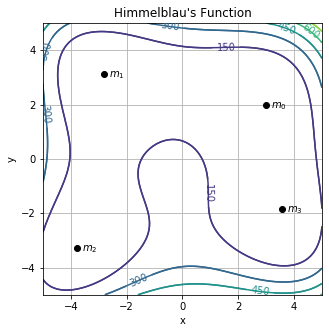

In [21]:
ax = show_contour_plot(X, Y, Z, min_himmelblau, title="Himmelblau's Function")
plt.show()

## Setup optimization test problem

Note: In practice, the function we are trying to opimize would be costly to compute

In [22]:
# Choose optimization function
function_to_minimize = rosenbrock

# Define bounded region of parameter space
pbounds = {
    'x': (-2, 2), 
    'y': (-0.5, 3)
}

# Provide minima (for plots)
minima = min_rosenbrock

# Optimizer only has a maximise method so need to
# invert our function to minimize
def objective_function(x, y):
    return 1 / function_to_minimize(x, y)

# Initialize optimizer
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [23]:
# Start with some random searches
optimizer.maximize(
    init_points=5,
    n_iter=0,
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        |  0.002725 | -0.3319   |  2.021    |
|  2        |  0.000838 | -2.0      |  0.5582   |
|  3        |  0.002091 | -1.413    | -0.1768   |
|  4        |  0.0125   | -1.255    |  0.7095   |
|  5        |  0.00668  | -0.4129   |  1.386    |


In [24]:
n_iter = 10
optimizer.maximize(
    init_points=0,
    n_iter=n_iter,
)

best_params = optimizer.max['params']
best_reward = optimizer.max['target']
best_pt = [best_params[name] for name in ('x', 'y')]

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  6        |  0.000493 |  2.0      | -0.5      |
|  7        |  0.009174 | -2.0      |  3.0      |
|  8        |  0.009901 |  2.0      |  3.0      |
|  9        |  0.001405 |  2.0      |  1.334    |
|  10       |  0.02509  |  0.3579   | -0.5      |
|  11       |  0.09947  |  0.5874   |  0.03062  |
|  12       |  0.001449 |  0.6108   |  3.0      |
|  13       |  0.01374  |  1.149    |  0.4669   |
|  14       |  0.001859 | -0.8296   |  3.0      |
|  15       |  0.1627   | -0.1004   |  0.2322   |


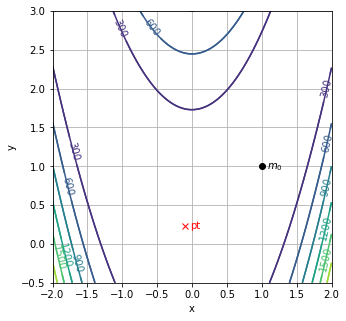

In [25]:
X, Y, Z = generate_plot_data(function_to_minimize, xlim=pbounds['x'], ylim=pbounds['y'])
show_contour_plot_with_pt(X, Y, Z, best_pt, minima)
plt.show()